In [2]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib

In [90]:
# carico il dataframe preprocessato

df_corr= joblib.load('dataframe_processato.joblib')



,yellow_cards,red_cards,goals,assists,minutes_played,height_in_cm,market_value_in_eur,eta
0,65,1,36,66,24571,175.0,1000000.0,38
1,4,2,0,2,10473,188.0,75000.0,39
2,41,0,6,6,19090,176.0,450000.0,32
3,13,0,54,58,17778,176.0,13000000.0,31
4,17,1,0,2,29055,188.0,700000.0,41
...,...,...,...,...,...,...,...,...
6174,1,0,1,1,493,193.0,400000.0,21
6175,1,0,1,2,265,182.0,100000.0,19
6176,0,0,0,0,26,181.0,150000.0,19
6177,0,0,0,0,173,176.0,150000.0,18


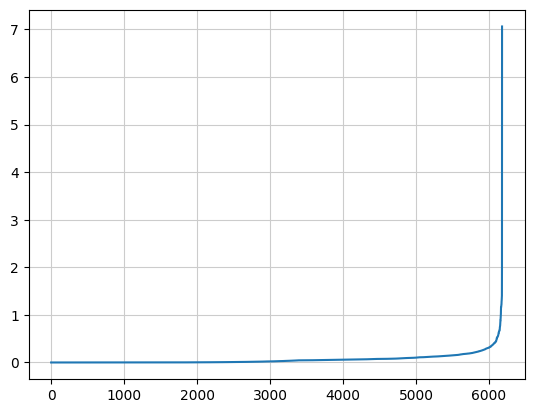

In [41]:
# andiamo ad utilizzare il metodo del k-dist per individuare il numero ottimale di epsilon

colonnes_per_dbscan = ['yellow_cards', 'goals', 'minutes_played']
df_dbscan = df_corr[colonnes_per_dbscan]

# Standardizza le colonne per avere media zero e deviazione standard uno
scaler = StandardScaler()
df_dbscan_scaled = scaler.fit_transform(df_dbscan)

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_dbscan_scaled)
distances, indices = neighbors_fit.kneighbors(df_dbscan_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid(True, color = "#CCCCCC")
plt.plot(distances)
#plt.savefig("../../images/clustering/dbscan/k_dist.png")# non salviamo perche modificato a mano

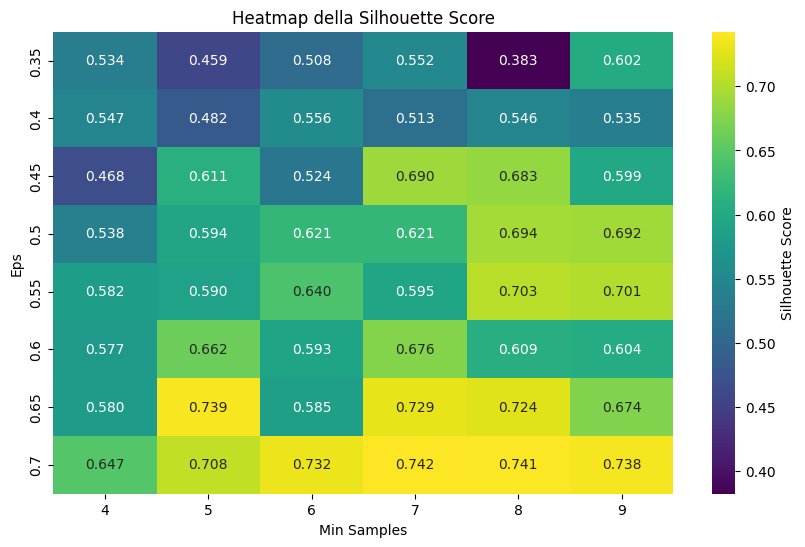

In [47]:

# Definisci i range per eps e min_samples
eps_values = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
min_samples_values = range(4, 10)
 
# Inizializza una matrice per memorizzare i risultati della silhouette score
silhouette_matrix = np.zeros((len(eps_values), len(min_samples_values)))
 
# Itera su eps e min_samples
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Utilizza DBSCAN per il clustering con i parametri correnti
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_dbscan_scaled)
        # Calcola la silhouette score e memorizzala nella matrice
        silhouette_avg = silhouette_score(df_dbscan_scaled, labels)
        silhouette_matrix[i, j] = silhouette_avg



# Crea un heatmap della matrice della silhouette score
plt.figure(figsize=(10, 6))
sns.heatmap(silhouette_matrix, annot=True, fmt=".3f",
            xticklabels=min_samples_values, yticklabels=np.round(eps_values, 3),
            cmap="viridis", cbar_kws={'label': 'Silhouette Score'})

#plt.savefig("../../images/silhoutte_dbscan_piccola.png")
plt.xlabel('Min Samples')
plt.ylabel('Eps')
plt.title('Heatmap della Silhouette Score')
plt.show()



C:\Users\nicol\AppData\Local\Temp\ipykernel_17616\246950530.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dbscan['dbscan_cluster'] = labels


dbscan_cluster
 0    5828
-1     321
 1      13
 2      11
 3       6
Name: count, dtype: int64

Cluster 0:
yellow_cards: Min = 0, Max = 83
goals: Min = 0, Max = 79
minutes_played: Min = 1, Max = 32482

Cluster 1:
yellow_cards: Min = 5, Max = 21
goals: Min = 0, Max = 0
minutes_played: Min = 33714, Max = 40794

Cluster 2:
yellow_cards: Min = 24, Max = 34
goals: Min = 71, Max = 88
minutes_played: Min = 14481, Max = 17886

Cluster 3:
yellow_cards: Min = 74, Max = 81
goals: Min = 13, Max = 18
minutes_played: Min = 17758, Max = 19631

Cluster -1:
yellow_cards: Min = 1, Max = 131
goals: Min = 0, Max = 418
minutes_played: Min = 7176, Max = 43689


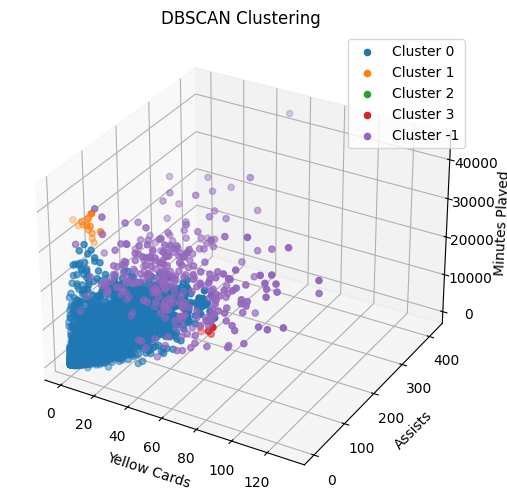

Silhouette Score: 0.508018142117142


In [76]:
# scegliamo un epsilon = 0.5

 
# Utilizza DBSCAN per il clustering
dbscan = DBSCAN(eps=0.35, min_samples=6)
labels = dbscan.fit_predict(df_dbscan_scaled)
 
# Aggiungi le etichette del cluster al DataFrame originale
df_dbscan['dbscan_cluster'] = labels
 
# Visualizza il conteggio dei cluster ottenuti
print(df_dbscan['dbscan_cluster'].value_counts())
 

# Visualizza un plot 3D dei dati colorati in base ai cluster DBSCAN
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
 
# Itera attraverso i cluster distinti
for cluster in set(labels):
    cluster_data = df_dbscan[df_dbscan['dbscan_cluster'] == cluster]

      

    ax.scatter3D(cluster_data['yellow_cards'], cluster_data['goals'], cluster_data['minutes_played'],
                 label=f'Cluster {cluster}')
    
# qeusto blocco ci serve per stamparci per ogni cluster i valori max e min di ciascuna feature, in modo da capire cosa rappresentano i cluster
    print(f'\nCluster {cluster}:')
    for column in ['yellow_cards', 'goals', 'minutes_played']:
        max_value = cluster_data[column].max()
        min_value = cluster_data[column].min()
        print(f'{column}: Min = {min_value}, Max = {max_value}')
 

ax.set_xlabel('Yellow Cards')
ax.set_ylabel('Assists')
ax.set_zlabel('Minutes Played')
ax.set_title('DBSCAN Clustering')

ax.legend()
#ax.view_init(elev=40, azim=-140) #per ruotare
#plt.savefig("../../images/dbscan_nonruotato.png")
plt.show()


# Calcola la silhouette score
silhouette_avg = silhouette_score(df_dbscan_scaled, labels)
 
print(f'Silhouette Score: {silhouette_avg}')